# Particle Swarm and the Eggholder Challenge

On April 10th, 2025, I invited my numerical methods class to test the Nelder-Mead method on any function from Wikipedia's [list of test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization).

These functions are designed as benchmarks precisely because they are challenging—many have multiple local minima where an optimizer can become trapped, making it difficult to find the global minimum.

One student chose a particularly challenging function: the eggholder function. Below is a surface plot of the eggholder function (you can see why it earned its name), followed by a contour plot. Note that this function presents an additional challenge: its global minimum lies on the boundary of the domain!


Here is the eggholder function

\begin{equation}
f(x,y) = -(y+47)\sin\left(\sqrt{\left|\frac{x}{2} + (y+47)\right|}\right) - x\sin\left(\sqrt{|x-(y+47)|}\right),
\end{equation}

with domain $x, y \in [-512, 512]$ and global minimum at $(x, y) = (512, 404.2319)$ where $f(512, 404.2319) \approx -959.6407$.


In [27]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

def rosenbrock(X):
    """
    Rosenbrock function (banana function).
    
    Global minimum at (1, 1) where f(1, 1) = 0.
    
    Parameters
    ----------
    X : array_like
        Input array [x, y]
    
    Returns
    -------
    float
        Function value
    """
    a = 1
    b = 100
    return (a - X[0])**2 + b * (X[1] - X[0]**2)**2


def eggholder(X):
    """
    Eggholder function.
    
    Global minimum at (512, 404.2319) where f ≈ -959.6407.
    Domain: x, y ∈ [-512, 512]
    
    Parameters
    ----------
    X : array_like
        Input array [x, y]
    
    Returns
    -------
    float or ndarray
        Function value(s)
    """
    x, y = X
    term1 = -(y + 47) * np.sin(np.sqrt(np.abs(x / 2 + y + 47)))
    term2 = -x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    return term1 + term2


def rastrigin(X):
    """
    Rastrigin function.
    
    Global minimum at (0, 0) where f(0, 0) = 0.
    Has many regularly distributed local minima.
    
    Parameters
    ----------
    X : array_like
        Input array [x, y]
    
    Returns
    -------
    float or ndarray
        Function value(s)
    """
    x, y = X
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

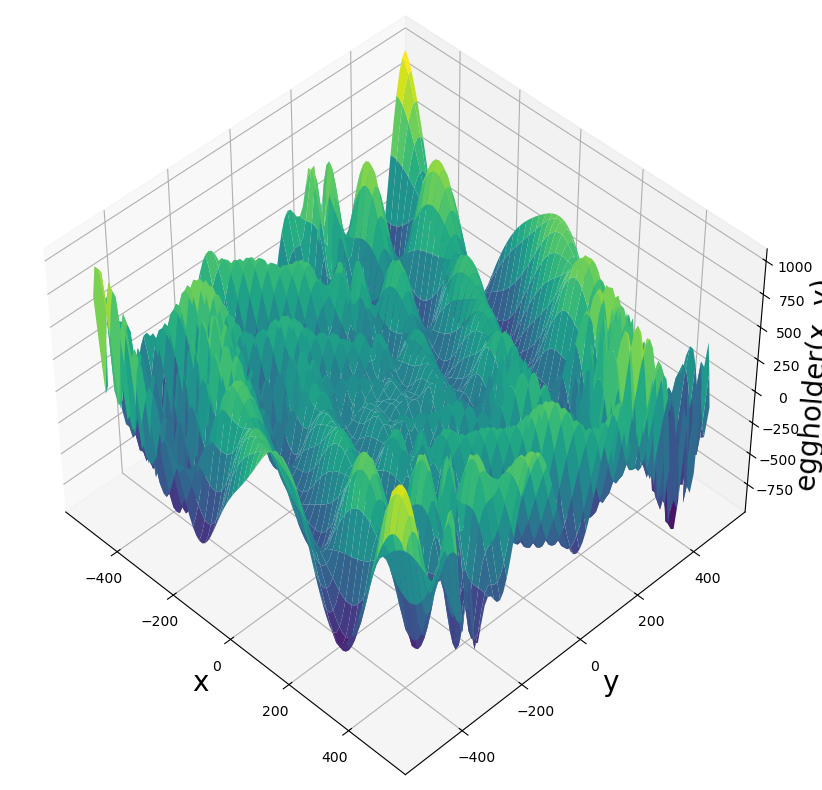

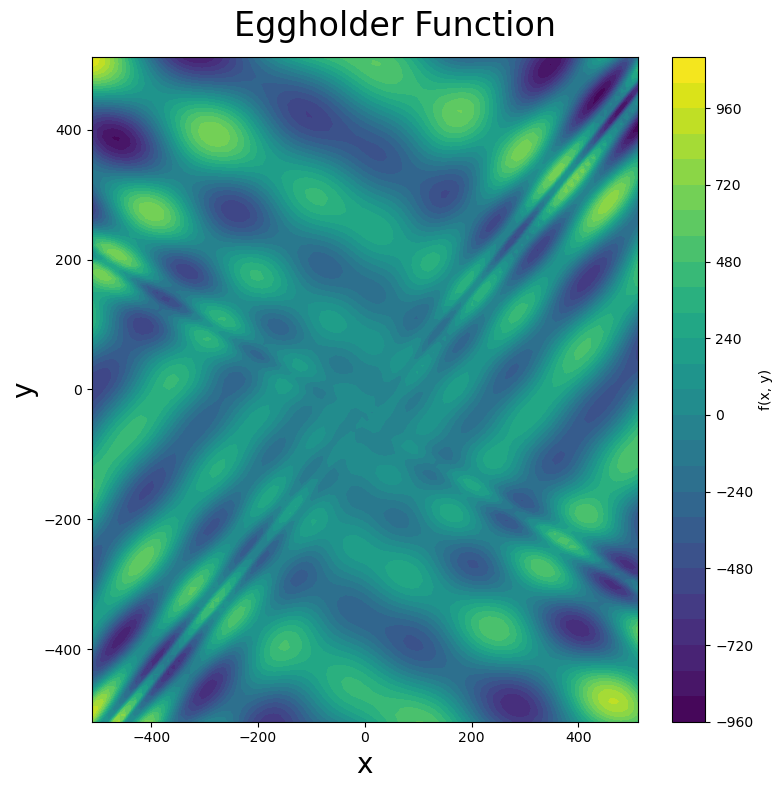

In [4]:
# Create grid for eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])
z = eggholder(xy)

# 3D surface plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, z, cmap='viridis')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('eggholder(x, y)', fontsize=20)
plt.tight_layout()
fig.savefig("eggholder_surface.png", dpi=150, bbox_inches='tight')
plt.show()

# Contour plot
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle("Eggholder Function", fontsize=24)
contour = ax.contourf(xgrid, ygrid, z, levels=30, cmap='viridis')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
plt.colorbar(contour, ax=ax, label='f(x, y)')
plt.tight_layout()
fig.savefig("eggholder_contour.png", dpi=150, bbox_inches='tight')
plt.show()

Examine the surface plot of the eggholder function. Why do you think it earned the name "eggholder"? Describe the visual features that make this name appropriate.

Nelder-Mead gloriously failed at finding the minimum of the eggholder function—it was no match for this challenging landscape.

However, I wouldn't call this a complete failure. First, I knew going in that Nelder-Mead wouldn't work for all the functions on that list. Second, failures create opportunities to learn something new. 

How does the eggholder fare against particle swarm optimization?

**Particle Swarm Optimization**

[Particle swarm optimization (PSO)](https://en.wikipedia.org/wiki/Particle_swarm_optimization) is a gradient-free optimization method that works by maintaining an ensemble of particles—the swarm—that collectively search the solution space. Each particle evaluates the objective function and iteratively improves its position based on two pieces of information: its own search history and the best solution found by the entire swarm so far.

Interestingly, particle swarm was originally developed for modeling social behavior! This connection to social dynamics opens up a fascinating field called swarm intelligence. The [original 1995 paper on particle swarm optimization](https://www.cs.tufts.edu/comp/150GA/homeworks/hw3/_reading6%201995%20particle%20swarming.pdf) is worth reading if you want to understand the biological inspiration behind the algorithm.

**A Related Story: The Vicsek Model**

This topic reminded me of a project I worked on with a biology student studying the Vicsek model, which describes collective behavior in biological systems such as bird flocking and fish schooling. The mathematics underlying swarm intelligence and collective motion seemed to be connected; I am curious. Below is an animation of the Vicsek model that my collaborator and I created.

In [47]:
from IPython.display import Video

Video("vicsek_first_take.mp4", embed=True, width=400)

Well, SciPy doesn't include a particle swarm optimizer in its standard library (at least not that I could find), so I coded my own implementation from scratch.

**Results:**

My vanilla particle swarm method successfully found the eggholder minimum at $(512.0, 404.2318)$ with a function value of $-959.6407$. The known global minimum is at $(512, 404.2319)$ with $f \approx -959.6407$. Not too bad for a from-scratch optimizer!

Below is an animation of the particle swarm method navigating the eggholder function landscape. The particles are like a swarm of bees that are a bit lost at first, exploring the rugged terrain, before eventually finding the honey.

Here is my very crude particle swarm method. 

In [21]:
# Particle class (your original - just adding self.score initialization)
class Particle:
    def __init__(self, objective, n_dim, bounds, vmax):
        self.objective = objective
        self.position = np.random.uniform(bounds[0], bounds[1], n_dim)
        self.velocity = np.random.uniform(-1, 1, n_dim) * vmax
        
        # Initialize best position and score 
        self.best_position = np.copy(self.position)
        self.best_score = self.objective(self.position)
        self.score = self.best_score  # Add this line
        
    def update_velocity(self, global_best_position, w, phi_p, phi_g):
        r1, r2 = np.random.rand(2), np.random.rand(2)
        cognitive = phi_p * r1 * (self.best_position - self.position)
        social = phi_g * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social
        
    def update_position(self, bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, bounds[0], bounds[1])
        self.score = self.objective(self.position)
        if self.score < self.best_score:
            self.best_score = self.score
            self.best_position = np.copy(self.position)


In [22]:
# PSO function with stopping criteria
def pso(objective, n_particles, max_iter, n_dim, bounds, vmax, w=0.5, phi_p=1.5, phi_g=1.5, 
        tol=1e-6, patience=10, history=False):
    
    swarm = [Particle(objective, n_dim, bounds, vmax) for _ in range(n_particles)]
    global_best = min(swarm, key=lambda p: p.best_score)
    global_best_position = global_best.best_position
    global_best_score = global_best.best_score
    
    # Stopping criteria tracking
    no_improvement_count = 0
    prev_best_score = global_best_score
    
    if history: 
        X = np.zeros((max_iter + 1, n_particles, n_dim))
        scores = np.zeros((max_iter + 1, n_particles))
        for i in range(n_particles): 
            X[0, i, :] = swarm[i].position
            scores[0, i] = swarm[i].score
    
    for t in range(max_iter):
        for i in range(n_particles):
            swarm[i].update_velocity(global_best_position, w, phi_p, phi_g)
            swarm[i].update_position(bounds)
            
            if history:
                X[t+1, i, :] = swarm[i].position
                scores[t+1, i] = swarm[i].score
            
            if swarm[i].best_score < global_best_score:
                global_best_score = swarm[i].best_score
                global_best_position = np.copy(swarm[i].best_position)
        
        # Check stopping criterion
        improvement = prev_best_score - global_best_score
        if improvement < tol:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Converged: No improvement for {patience} iterations at iteration {t+1}")
                if history:
                    # Trim arrays to actual iterations used
                    X = X[:t+2]  # +2 because we need initial + all completed iterations
                    scores = scores[:t+2]
                break
        else:
            no_improvement_count = 0
        
        prev_best_score = global_best_score
        
        # Print progress every 30 iterations
        if (t+1) % 30 == 0:
            print(f"Iteration {t+1}: Best score = {global_best_score:.4f}")
    
    if history: 
        return global_best_position, global_best_score, X, scores
    else: 
        return global_best_position, global_best_score

In [25]:
# Test with stopping criteria
np.random.seed(42)
best_pos, best_val, X, scores = pso(eggholder, 100, 200, 2, (-512, 512), 1, 
                                     tol=1e-4, patience=20, history=True)
print("\nFinal Results:")
print("Best Position:", best_pos)
print("Best Score:", best_val)
print(f"Actual iterations used: {len(X) - 1}")

Iteration 30: Best score = -959.6407
Converged: No improvement for 20 iterations at iteration 36

Final Results:
Best Position: [512.         404.23180693]
Best Score: -959.640662720847
Actual iterations used: 36


In [40]:
# Create animation of particle swarm
fig, ax = plt.subplots(figsize=(6, 6))
#fig.suptitle("Particle Swarm Optimization on Eggholder Function", fontsize=20)

# Set up plot
ax.set_xlim(-520, 520)
ax.set_ylim(-520, 520) 
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

# Contour plot of objective function
ax.contourf(xgrid, ygrid, z, levels=30, cmap='viridis', alpha=0.8)

# Mark the global minimum
ax.plot(512, 404.2319, 'w*', markersize=20, markeredgecolor='black', 
        markeredgewidth=2, label='Global minimum')

# Initialize particle scatter plot
particles, = ax.plot([], [], 'o', color='red', markersize=8, alpha=0.7, label='Particles')

ax.legend(loc='lower left', fontsize=12)

plt.close()

def init():
    """Initialize animation."""
    particles.set_data([], []) 
    return particles,

def draw(i): 
    """Update function for each frame."""
    particles.set_data(X[i, :, 0], X[i, :, 1])
    return particles,

# Create animation
anim = animation.FuncAnimation(fig, draw, init_func=init, 
                               frames=X.shape[0], interval=200, 
                               blit=True, repeat=True)

# Display or save
# plt.show()
# anim.save('pso_eggholder.gif', writer='pillow', fps=10)

In [41]:
HTML(anim.to_html5_video())

I will test the particle swarm method on the Rosenbrock and Rastrigin functions. These functions have known global minima. 

- Rosenbrock function: Global minimum at $(1, 1)$ where $f(1, 1) = 0$
- Rastrigin function: Global minimum at $(0, 0)$ where $f(0, 0) = 0$

Here are the results. 

In [44]:
# Run PSO on Rosenbrock function
best_pos, best_val= pso(rosenbrock,100, 100, 2, (-3,3),1)
print("Best Position:", best_pos)
print("Best Score (minimum value):", best_val)

Iteration 30: Best score = 0.0000
Converged: No improvement for 10 iterations at iteration 32
Best Position: [1.00457599 1.00926469]
Best Score (minimum value): 2.1781860670255866e-05


In [45]:
# Run PSO on Rastrigin function
best_pos, best_val= pso(rastrigin,100, 100, 2, (-6,6),1)
print("Best Position:", best_pos)
print("Best Score (minimum value):", best_val)

Iteration 30: Best score = 0.0000
Converged: No improvement for 10 iterations at iteration 38
Best Position: [-1.16952308e-06 -5.54766310e-06]
Best Score (minimum value): 6.3771850022931176e-09
